## Table of contents
   1. Introduction: Business Problem
   2. Data Requirements
   3. Methodology
   4. Analysis
   5. Results
   6. Discussion
   7. Conclusion

## Introduction: Business Problem 

This project deals with discussing the neighborhoods of **Bangalore, The Detroit of India**. This project would specifically help Business people planning to start **Restaurants, Hotels, etc**. in Bangalore, Karanataka, India.

The **Foursquare API** is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the **k-means clustering algorithm** is used to achieve the task. The optimal number of clusters can be obtained using **silhouette score. Folium visualization library** can be used to visualize the clusters superimposed on the map of Banglore city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

**Import the libraries**

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


## Data Requirements
Bangalore has multiple neighborhoods. Lets use the following dataset which has the list of locations in bangalore along with their Latitude and Longitude:

In [6]:
blr_df = pd.read_csv("blr_neighborhoods.csv")
blr_df.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Agram,45.813177,15.977048
1,1,Amruthahalli,13.066513,77.596624
2,2,Attur,11.663711,78.533551
3,3,Banaswadi,13.014162,77.651854
4,4,Bellandur,58.235358,26.683116


In [7]:
blr_df.shape

(352, 4)

In [8]:
blr_df = blr_df.drop("Unnamed: 0", axis=1)
blr_df.head()

,Neighborhood,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683116


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Bangalore. The latitude and longitude of Bangalore can be obtained using the Geolocator library.

In [10]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Bangalore are 12.9791198, 77.5912997.


**Bangalore Map:**

In [11]:
# create map of Toronto using latitude and longitude values
blr_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
blr_map

**Bangalore Map with the neighborhoods superimposed on top:**

In [12]:
# add neighborhood markers to map
for lat, lng, location in zip(blr_df['Latitude'], blr_df['Longitude'], blr_df['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(blr_map)  

blr_map

**Define Foursquare Credentials and Version**

In [13]:
#foursquare account details
CLIENT_ID = '31TGRMWWKUGLYRAJ2I40YSOEKHLSB1Z43U3GXVNK2MT1ZLPQ' # your Foursquare ID
CLIENT_SECRET = '33FCH2XYAAT5ONXPJNWTX0B1KAUWOPUENRAGAG52OICO5SQN' # your Foursquare Secret
VERSION = '20210405'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 31TGRMWWKUGLYRAJ2I40YSOEKHLSB1Z43U3GXVNK2MT1ZLPQ
CLIENT_SECRET:33FCH2XYAAT5ONXPJNWTX0B1KAUWOPUENRAGAG52OICO5SQN


**Explore neighborhoods in Bangalore**

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the blr_df neighborhoods dataframe and store the venues data returned in the blr_venues pandas dataframe.

In [15]:
blr_venues = getNearbyVenues(names = blr_df['Neighborhood'],
                                 latitudes = blr_df['Latitude'],
                                 longitudes = blr_df['Longitude']
                                 )

print(blr_venues.shape)
blr_venues.head()

(768, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Gajbica,45.813531,15.979550,Bistro
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant


A total of 768 venues were obtained. Now lets check the number of venues returned per neighborhood

In [17]:
blr_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Achitnagar,1,1,1,1,1,1
Adugodi,6,6,6,6,6,6
Agram,94,94,94,94,94,94
Akkur,30,30,30,30,30,30
Alahalli,1,1,1,1,1,1
Amruthahalli,3,3,3,3,3,3
Anekal,2,2,2,2,2,2
Arudi,3,3,3,3,3,3
Attibele,3,3,3,3,3,3


From the above dataframe we can see that Agram returned the highest number of venues i.e. 94. Now lets check the unique categories of all the venues returned.

In [19]:
print('There are {} uniques categories.'.format(len(blr_venues['Venue Category'].unique())))

There are 172 uniques categories.


##  Methodology

Now, we have the neighborhoods data of Bangalore (**352 neighborhoods**). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of **768 venues** have been obtained in the whole city and **172 unique categories**. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the **neighborhoods with more than 10 venues**.

We can perform one hot encoding on the obtained data set and use it find the **10 most common venue category** in each neighborhood. Then clustering can be performed on the dataset. Here **K - Nearest Neighbor** clustering technique have been used. To find the optimal number of clusters **silhouette score** metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category

## Analysis

First, lets visualize the number of venues obtained in all the neighborhoods of Bangalore.

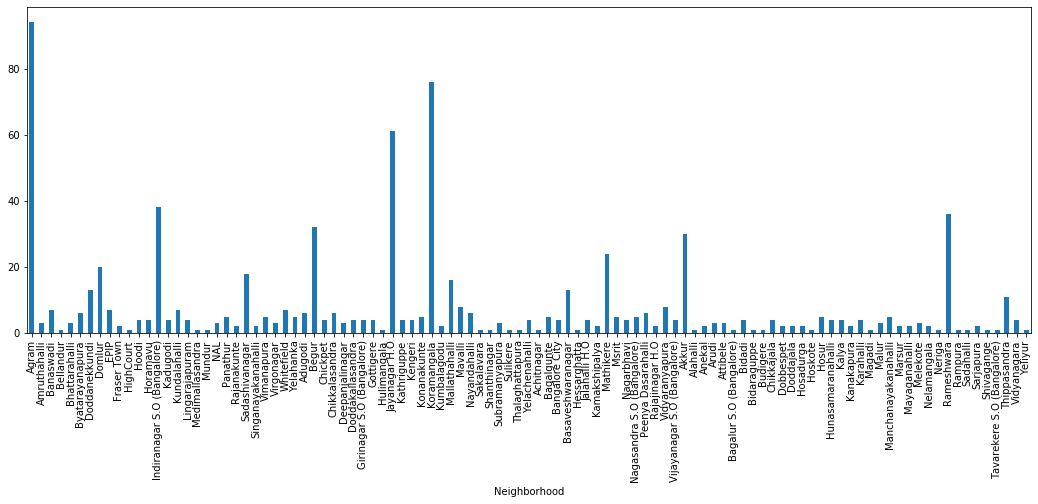

In [20]:
df = blr_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained

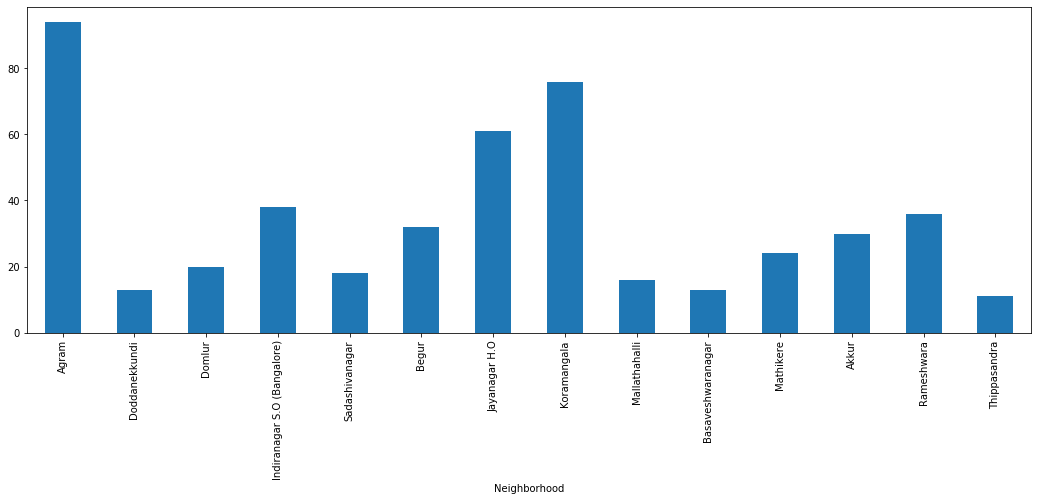

In [21]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, blr_venues_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [22]:
blr_venues_top = blr_venues[blr_venues['Neighborhood'].isin(df.index.tolist())]
blr_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Gajbica,45.813531,15.979550,Bistro
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant


**One hot encoding**

In [23]:
blr_onehot = pd.get_dummies(blr_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blr_onehot['Neighborhood'] = blr_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = blr_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
blr_onehot = blr_onehot.reindex(columns = fixed_columns)

print(blr_onehot.shape)
blr_onehot.head()

(482, 119)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Fried Chicken Joint,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Irish Pub,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agram,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [24]:
blr_grouped = blr_onehot.groupby('Neighborhood').mean().reset_index()
print(blr_grouped.shape)
blr_grouped.head()

(14, 119)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Fried Chicken Joint,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Irish Pub,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0.0,0.0,0.000000,0.010638,0.010638,0.000000,0.000000,0.085106,0.0,0.042553,0.0,0.0,0.0,0.010638,0.021277,0.0,0.042553,0.0,0.000000,0.0,0.0000,0.000000,0.010638,0.021277,0.0000,0.010638,0.0000,0.0,0.0,0.0,0.010638,0.042553,0.0,0.000000,0.0,0.010638,0.0,0.010638,0.010638,0.010638,0.010638,0.0,0.0,0.0,0.000000,0.0,0.0,0.010638,0.0,0.0,0.010638,0.042553,0.021277,0.021277,0.010638,0.000000,0.010638,0.0,0.010638,0.021277,0.010638,0.000000,0.0,0.0000,0.010638,0.010638,0.0,0.0,0.042553,0.0,0.0000,0.0,0.0,0.010638,0.000000,0.000000,0.000000,0.021277,0.0,0.000000,0.0,0.021277,0.031915,0.0,0.000000,0.000000,0.010638,0.010638,0.021277,0.074468,0.031915,0.0,0.031915,0.010638,0.000000,0.021277,0.021277,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.010638,0.000,0.0,0.0,0.0,0.031915,0.000000,0.010638,0.0,0.0,0.0,0.021277,0.0,0.0
1,Akkur,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.066667,0.0,0.0000,0.066667,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.0,0.0,0.066667,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.0,0.000000,0.000000,0.0,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0000,0.000000,0.000000,0.200,0.0,0.0,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Basaveshwaranagar,0.0,0.0,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.076923,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.307692,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.153846,0.0,0.000000,0.000000,0.076923,0.076923,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

The following function returns the top_venues of each neighborhood.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe **neighborhoods_venues_sorted**.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blr_grouped['Neighborhood']

for ind in np.arange(blr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Dessert Shop,Bistro,Historic Site,Café,Theater,Restaurant,Pedestrian Plaza
1,Akkur,Supermarket,Department Store,Bakery,Sandwich Place,Snack Place,Clothing Store,Bar,Discount Store,Toy / Game Store,Pharmacy
2,Basaveshwaranagar,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Snack Place,Juice Bar,Asian Restaurant,Karnataka Restaurant,Burger Joint,Sandwich Place,Farmers Market
3,Begur,Café,Supermarket,Burger Joint,Korean Restaurant,Climbing Gym,Park,Spanish Restaurant,Comedy Club,Mini Golf,Bar
4,Doddanekkundi,Multiplex,Indian Restaurant,Fried Chicken Joint,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar,Mediterranean Restaurant


**Cluster Neighborhoods**

Here k-Nearest Neighborhoods clustering technique is used. Lets use the **silhouette_score** to obtain the best value for the number of clusters.

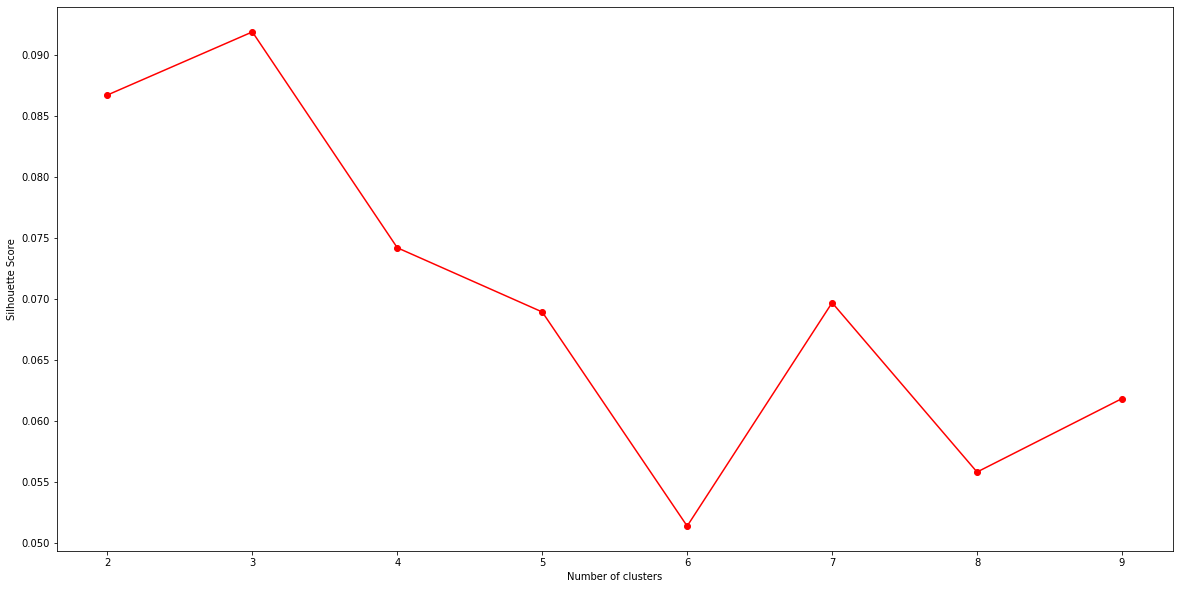

In [28]:
blr_grouped_clustering = blr_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(blr_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(blr_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 8. So, lets consider the number of clusters as 3.

In [30]:
# select best number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 1, 1, 3])

Add the cluster labels to the **neighborhoods_venues_sorted** dataframe. And lets create a new datframe **blr_merged** which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blr_merged = blr_venues_top[blr_venues_top.columns[0:3]].drop_duplicates()
blr_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blr_merged = blr_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

blr_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,45.813177,15.977048,0,Bar,Plaza,Mediterranean Restaurant,Dessert Shop,Bistro,Historic Site,Café,Theater,Restaurant,Pedestrian Plaza
1,Doddanekkundi,12.975720,77.694042,0,Multiplex,Indian Restaurant,Fried Chicken Joint,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar,Mediterranean Restaurant
2,Domlur,12.962467,77.638196,0,Café,Indian Restaurant,Food & Drink Shop,Smoke Shop,Sports Bar,Chinese Restaurant,Rajasthani Restaurant,Pub,Deli / Bodega,Lounge
3,Indiranagar S.O (Bangalore),12.973291,77.640467,0,Pub,Lounge,Bakery,Restaurant,Cupcake Shop,Café,Cocktail Bar,Italian Restaurant,Indian Restaurant,Gym
4,Sadashivanagar,13.007708,77.579589,0,Department Store,Coffee Shop,Indian Restaurant,Gourmet Shop,Dessert Shop,Plaza,Seafood Restaurant,Chinese Restaurant,Performing Arts Venue,Ice Cream Shop


## Results

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

**Cluster 1**

In [42]:
blr_merged.loc[blr_merged['Cluster Labels'] == 0, blr_merged.columns[[0] + list(range(4, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Dessert Shop,Bistro,Historic Site,Café,Theater,Restaurant,Pedestrian Plaza
1,Doddanekkundi,Multiplex,Indian Restaurant,Fried Chicken Joint,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar,Mediterranean Restaurant
2,Domlur,Café,Indian Restaurant,Food & Drink Shop,Smoke Shop,Sports Bar,Chinese Restaurant,Rajasthani Restaurant,Pub,Deli / Bodega,Lounge
3,Indiranagar S.O (Bangalore),Pub,Lounge,Bakery,Restaurant,Cupcake Shop,Café,Cocktail Bar,Italian Restaurant,Indian Restaurant,Gym
4,Sadashivanagar,Department Store,Coffee Shop,Indian Restaurant,Gourmet Shop,Dessert Shop,Plaza,Seafood Restaurant,Chinese Restaurant,Performing Arts Venue,Ice Cream Shop
5,Begur,Café,Supermarket,Burger Joint,Korean Restaurant,Climbing Gym,Park,Spanish Restaurant,Comedy Club,Mini Golf,Bar
10,Mathikere,American Restaurant,Gym,Cosmetics Shop,Fast Food Restaurant,Café,Dessert Shop,Burger Joint,Bus Station,Diner,Bakery
11,Akkur,Supermarket,Department Store,Bakery,Sandwich Place,Snack Place,Clothing Store,Bar,Discount Store,Toy / Game Store,Pharmacy
12,Rameshwara,Clothing Store,Indian Restaurant,Fast Food Restaurant,Donut Shop,Ice Cream Shop,Electronics Store,Coffee Shop,American Restaurant,Cocktail Bar,Restaurant


In [43]:
cluster1 = blr_merged.loc[blr_merged['Cluster Labels'] == 0, blr_merged.columns[[0] + 
                                                                                    list(range(4, blr_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Café                    5
Indian Restaurant       5
Restaurant              4
Fast Food Restaurant    3
Bar                     3
Dessert Shop            3
Coffee Shop             3
Bakery                  3
American Restaurant     2
Ice Cream Shop          2
dtype: int64


**Cluster 2**

In [44]:
blr_merged.loc[blr_merged['Cluster Labels'] == 1, blr_merged.columns[[0] + list(range(4, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Jayanagar H.O,Indian Restaurant,Café,Juice Bar,Chinese Restaurant,Mobile Phone Shop,Fast Food Restaurant,Restaurant,Sandwich Place,Hotel,Dessert Shop
7,Koramangala,Indian Restaurant,Café,Coffee Shop,Pub,Italian Restaurant,Kerala Restaurant,Ice Cream Shop,Chinese Restaurant,Juice Bar,Snack Place
13,Thippasandra,Indian Restaurant,Bar,Pub,Fast Food Restaurant,Lounge,Tea Room,Flea Market,Vegetarian / Vegan Restaurant,Arcade,Donut Shop


In [45]:
cluster2 = blr_merged.loc[blr_merged['Cluster Labels'] == 2, blr_merged.columns[[0] + 
                                                                                    list(range(4, blr_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant       1
Farmers Market          1
Ice Cream Shop          1
Sandwich Place          1
Juice Bar               1
Fast Food Restaurant    1
Karnataka Restaurant    1
Snack Place             1
Burger Joint            1
Asian Restaurant        1
dtype: int64


**Cluster 3**

In [46]:
blr_merged.loc[blr_merged['Cluster Labels'] == 3, blr_merged.columns[[0] + list(range(4, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Mallathahalli,Café,Indian Restaurant,Bakery,Breakfast Spot,Market,South Indian Restaurant,Andhra Restaurant,History Museum,Food Court,Discount Store


In [47]:
cluster3 = blr_merged.loc[blr_merged['Cluster Labels'] == 3, blr_merged.columns[[0] + 
                                                                                    list(range(4, blr_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Café                    1
Farmers Market          1
Ice Cream Shop          1
Sandwich Place          1
Juice Bar               1
Karnataka Restaurant    1
Snack Place             1
Indian Restaurant       1
Burger Joint            1
Asian Restaurant        1
dtype: int64


## Discussion

Lets visulaize the top most common venue categories in each of the cluster.

IndexError: list index out of range

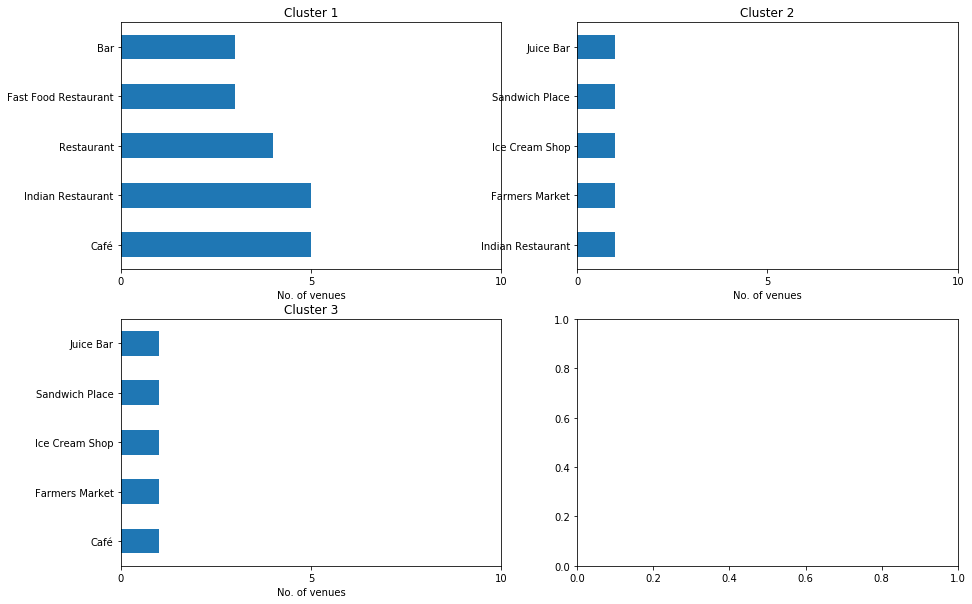

In [53]:
df_list = [venues1 ,venues2, venues3]
fig, axes = plt.subplots(2,2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

**1. Hotel**

The neighborhoods in cluster 1 has the greatest number of resturent, hence opening one here is  the best choice.  Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 1. such as the Agram, Doddanekkundi neighborhoods.

**2. Cafe**

The neighborhoods 2 has no  Cafe. By using the same procedure as above, the suitable cluster would be the Cluster 1 and Cluster 3, since it has Cafe.

**Map of Bangalore with the clusters superimposed on top**

This map can be used to find a suitable location to start a new business based on the category.

In [54]:
# create map
blr_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blr_merged['Neighborhood Latitude'], blr_merged['Neighborhood Longitude'], blr_merged['Neighborhood'], blr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(blr_clusters_map)
       
blr_clusters_map

## Conclusion 


Purpose of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 3 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.



A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

## Thank you